# Exploratory Data Analysis on Wave Data

### Wave1 dilated 50 data
Here we understand more about the data and how it is distrubuted.
Wave1 data are extracted features from raw images.
These images were processed via Cellprofiler pipelines

Specifically wave1 is looking at Gasdermin-D and Nuclei Staining from a cell painting experiment.

Further, nuclei were dilated using multiple values of pixel dilation. Here we use data for the 50 pixel dialation


### Wave3
Here we look into how the data are distributed in wave3, the same plate data as wave1 but with full cell painting dataset including the Gasdermin D channel for a total of 6 channels to analyze. 
These data sets contain extracted features from raw image dataset. See README for information as to how raw image data was processed.

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import pyarrow.parquet as pq
import umap

%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import itertools

sys.path.append("..")
from utils.utils import df_stats, plot_features_all_cluster

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lippincm/miniconda3/envs/Interstellar/lib/pyth

In [2]:
# function for EDA of each input feature extraction file:
def EDA_run(df, wave_label, subset_number=1500):
    """Function runs EDA on imported data frame

    Parameters:
    df: pandas dataframe
    wave_label: string of label for outputed graphs

    Return:
    graphs, and df stats

    """
    # Call function to display df shape and # of replicates present
    # df_stats from utuls module
    df_stats(df)
    # Drop na and reindex accordingly
    df = df.dropna()
    df.reindex()
    # Check for Nans again
    df_stats(df)
    # Understand categorical data such as treatment and dosing
    df[["Metadata_treatment", "Metadata_dose"]].drop_duplicates()
    # create a list with only columns from the data frame that start with "Metadata"

    treatments = df["Metadata_treatment"].unique()
    print(treatments)

    n_clusters = len(treatments)
    # print(n_clusters)
    samples = str(treatments).strip("[]")
    # print(samples)
    new_wave_label = f"{wave_label}_treatments:{samples}"

    df_subset = df.sample(n=subset_number)

    # Code snipptet for metadata extraction by Jenna Tomkinson
    df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

    # define which columns are data and which are descriptive
    df_descriptive = df_subset[df_metadata]
    df_values = df_subset.drop(columns=df_metadata)

    treatment_ids = df_descriptive["Metadata_treatment"]
    # Cluster data
    # clustering code adapted from https://www.kaggle.com/code/aussie84/clustering-with-kmeans-pca-tsne

    kmeans = KMeans(n_clusters=n_clusters)
    clustering_ori = kmeans.fit_predict(df_values)

    X = df_values
    # n_components is the number of dimensions to reduce to
    Xtsne = TSNE(n_components=2).fit_transform(X)
    dftsneFull = pd.DataFrame(Xtsne)

    dftsneFull["cluster"] = clustering_ori
    dftsneFull.columns = ["x1", "x2", "cluster"]
    dftsneFull["Treatment"] = (
        df_descriptive["Metadata_treatment"].reset_index().drop("index", axis=1)
    )
    # Figure Showing tSNE of Clusters vs Treatment
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    plot = sns.scatterplot(
        data=dftsneFull,
        x="x1",
        y="x2",
        hue="cluster",
        legend="full",
        alpha=0.7,
        ax=ax[0],
    )
    ax[0].set_title("Visualized on TSNE")
    plot = sns.scatterplot(
        data=dftsneFull,
        x="x1",
        y="x2",
        hue="Treatment",
        legend="full",
        alpha=0.7,
        ax=ax[1],
    )
    ax[1].set_title("Visualized on TSNE")
    fig.suptitle(
        f"Comparing Clusters vs Treatment tSNE for {subset_number} subset samples for {samples} treatments"
    )
    plt.savefig(f"Figures/tSNE_plate1/{new_wave_label}_tSNE_cluster.png")

## Wave1 Dialte50 Analysis

The dimensions of the data are: (68944, 841)
Number of total missing values across all columns: 6611
The dimensions of the data are: (68782, 841)
Number of total missing values across all columns: 0
['LPS' 'H2O2' 'ATP' 'Flagellin' 'Disulfiram' 'Thapsi' 'LPS + Nigericin'
 'DMSO 0.1%' 'Media only']


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


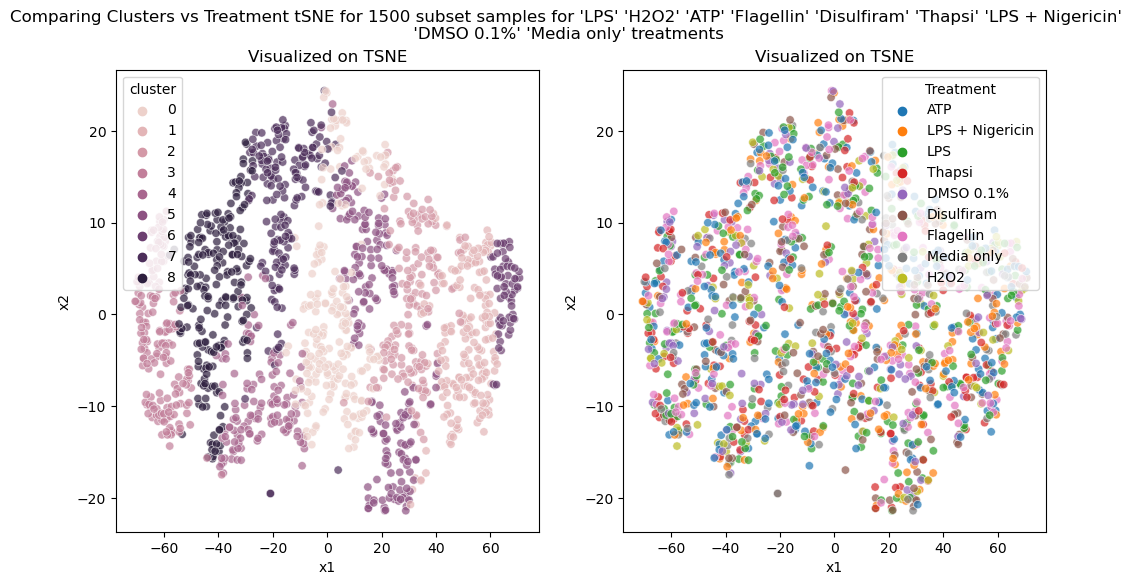

In [3]:
# Import data with low memory arg as the data are large
df = pd.read_csv(
    "../../Extracted_Features_(CSV_files)/interstellar_wave1_dilate50_sc.csv.gz",
    low_memory=False,
)
EDA_run(df, "wave1_dialte50")

Above tSNE shows that based on dimensionality reduction, there is no observable difference in treated cells. More sensitive methods such as machine learning models will need to be employed to achieve such.

Each Cluster has a similar distrubution in amount of features affecting its grouping

## Wave3 Single Cell Feature Extraction

The dimensions of the data are: (265283, 2473)
Number of total missing values across all columns: 5841
The dimensions of the data are: (264352, 2473)
Number of total missing values across all columns: 0
['LPS' 'Disulfiram' 'H2O2' 'Thapsi' 'ATP' 'LPS + Nigericin' 'Flagellin'
 'DMSO 0.1%' 'Media only']


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


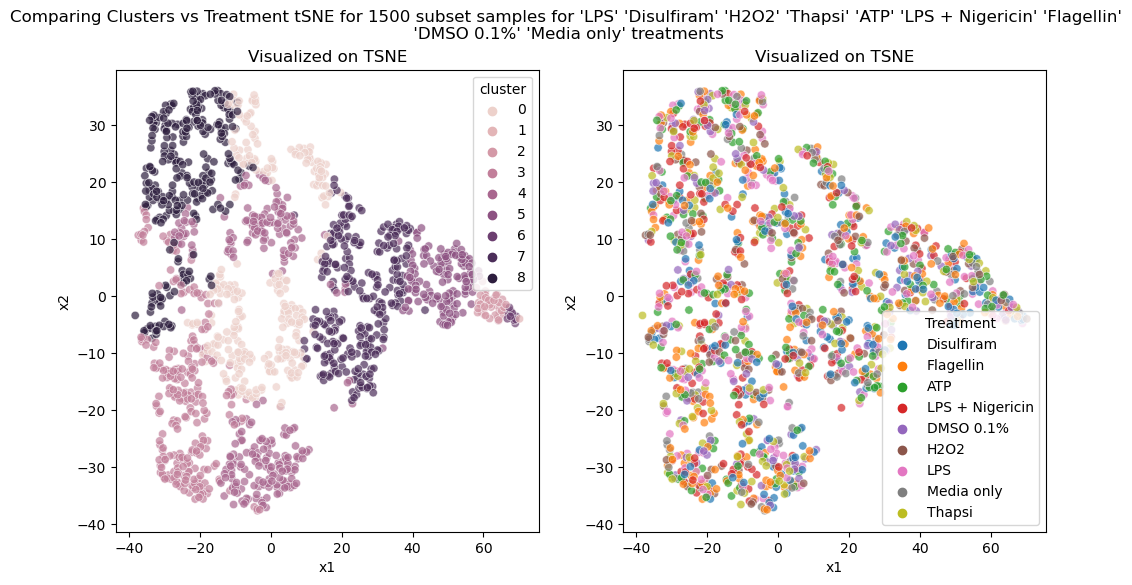

In [4]:
# Import data with low memory arg as the data are large
df = pd.read_csv(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc.csv.gz",
    low_memory=False,
)
EDA_run(df, "Wave3_sc")

## Wave3 Single Cell Normalized Features

The dimensions of the data are: (265283, 2473)
Number of total missing values across all columns: 5841
The dimensions of the data are: (264352, 2473)
Number of total missing values across all columns: 0
['LPS' 'Disulfiram' 'H2O2' 'Thapsi' 'ATP' 'LPS + Nigericin' 'Flagellin'
 'DMSO 0.1%' 'Media only']


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


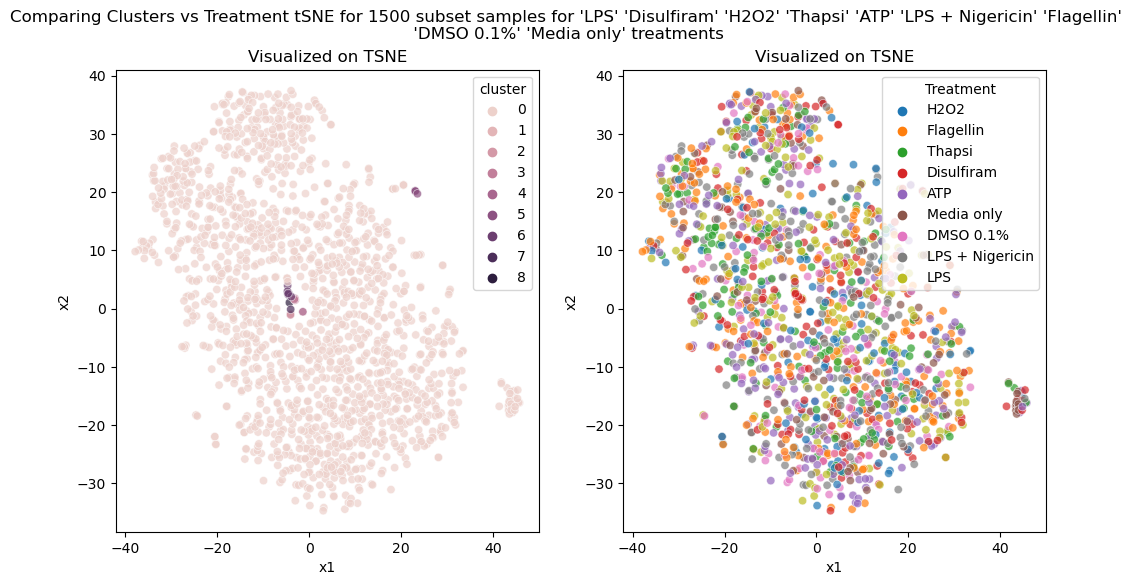

In [5]:
# Import data with low memory arg as the data are large
df = pd.read_csv(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_cellprofiler.csv.gz",
    low_memory=False,
)
EDA_run(df, "Wave3_sc_normalized")

## Wave3 Single Cell Normalized Selected Features
#### Feature Selection was performed in the data processeing repo. Check README for more information

The dimensions of the data are: (265283, 568)
Number of total missing values across all columns: 3394
The dimensions of the data are: (264368, 568)
Number of total missing values across all columns: 0
['LPS' 'Disulfiram' 'H2O2' 'Thapsi' 'ATP' 'LPS + Nigericin' 'Flagellin'
 'DMSO 0.1%' 'Media only']


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


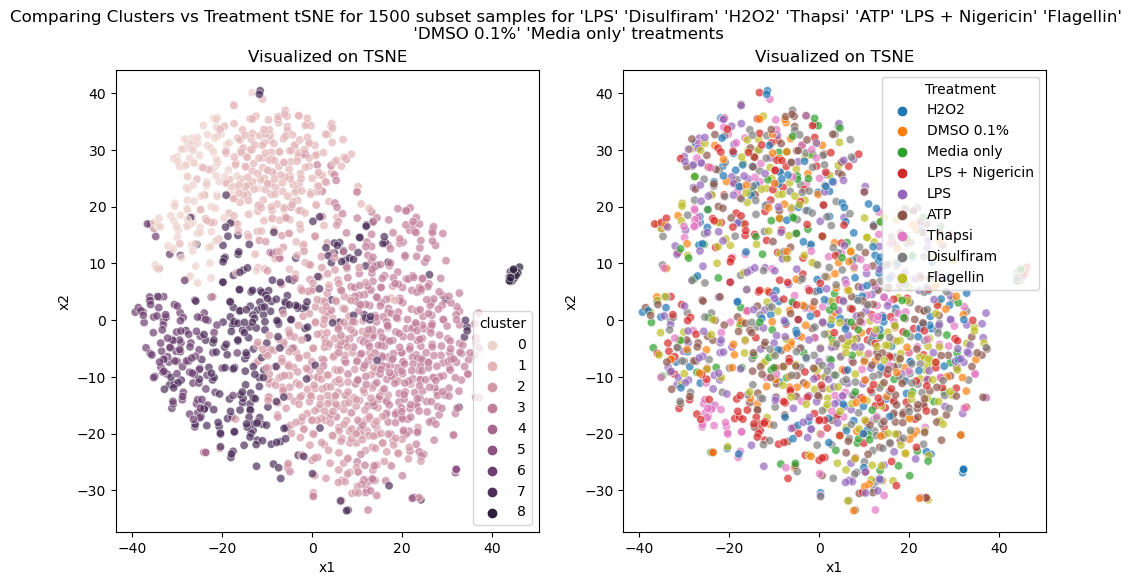

In [6]:
# Import data with low memory arg as the data are large
df = pd.read_csv(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz",
    low_memory=False,
)
EDA_run(df, "Wave3_sc_normalized_selected_features")

## Plate 2

In [7]:
# Set path to parquet file
path = pathlib.Path(
    "../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)
# Read in parquet file
df = pq.read_table(path).to_pandas()
# subset data frame to 1000 samples too much data results in poor clustering
df = df.sample(n=1000)

In [8]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [9]:
df_values = df_values.drop(
    columns=[
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ]
)

In [10]:
# set umap parameters
umap_params = umap.UMAP(
    n_components=2,
    spread=1.1,
    init="random",
    random_state=0,
)

In [11]:
# fit and transform data for umap
proj_2d = umap_params.fit_transform(df_values)

# add umap coordinates to dataframe of metadata and raw data
df_values["umap_1"] = proj_2d[:, 0]
df_values["umap_2"] = proj_2d[:, 1]

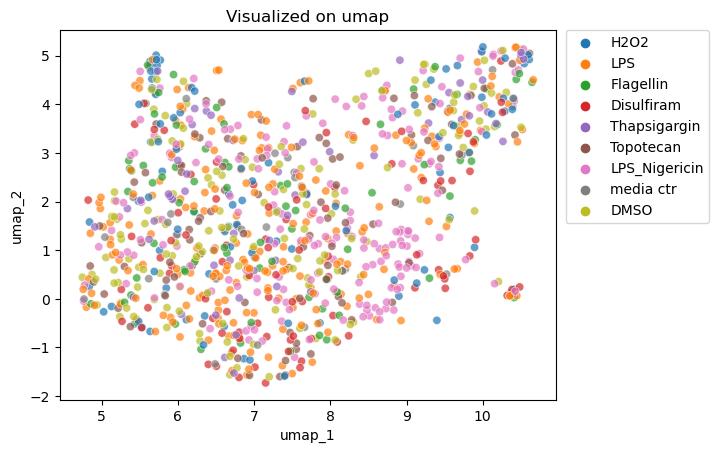

In [12]:
df_values["Treatment"] = df_descriptive["Metadata_Treatment"]
# Figure Showing tSNE of Clusters vs Treatment

sns.scatterplot(
    data=df_values,
    x="umap_1",
    y="umap_2",
    hue="Treatment",
    legend="full",
    alpha=0.7,
)
plt.title("Visualized on umap")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.savefig(f"Figures/umap_plate2/plate2_umap.png", bbox_inches="tight")